# Amino Acids


Many of the possible uptakes for MED4 are amino acid.

The goal of this notebook is to answer the questions
- Why are only a subset of amino acids in the list?
   1. run pFBA and search for the reactions that enable production of all amino acids from the amino acids on the uptake list, do they simply produce ammonium?
   2. use gap filling to identify missing reactions that may enable growth on the amino acids that are not sufficient for growth
GEMdiff


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cobra
import numpy as np
import seaborn as sns
import itertools
from matplotlib.colors import LogNorm, Normalize


In [2]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure

output_notebook()

Loading BokehJS ...

In [3]:
from bokeh.models import Range1d, Plot
from bokeh.plotting import from_networkx


In [4]:
import subprocess
import time


In [5]:
from cobra.flux_analysis import flux_variability_analysis
from cobra.flux_analysis import production_envelope


In [6]:
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,
    double_reaction_deletion)

In [7]:
pd.set_option('display.max_colwidth', None)

In [8]:
sns.hls_palette

<function seaborn.palettes.hls_palette(n_colors=6, h=0.01, l=0.6, s=0.65, as_cmap=False)>

In [9]:
import networkx as nx

In [10]:
# values from Ofaim at el.

PARAMETER_VALUES = [#"Name",     "Reaction ID",          "Lower bound", "UpperBound"
                   ["HCO3",      "HCO3EXcar",            -8,            0],
                   ["Nitrogen",  "AmmoniaEX",            -0.56,         0],
                   ["Phosphate", "FAKEOrthophosphateEX", -0.1,          0],
                   ["Light",     "LightEX",              -150,          0]]
CO2MAX = 0.82

# Block fake reactions
FAKE_TRANSPORT = ["AminosugarsOUT", "FAKEAAOUT", "FAKEABPOUT", "FAKEacpTRANS", "FAKEApoacpTRANS", "FAKEThioredoxinTRANS", 
                  "FreefattyacidsOUT", "7NMeth7carbOUT", "ArtificialproteinOUT", "FADOUT", "LipoylproteinTRANS", "MenaquinoneOUT", 
                  "NicotinateOUT", "THFpolyglutOUT", "Thiamin_dpOUT"]


In [11]:
def get_elements(rid):
    r = model.reactions.get_by_id(rid)
    m = r.reactants[0]    
    elements = m.elements.copy()
    
    res = {
        'reaction' : rid,
        'metabolite' : m.name,
        'N' : 'N' in elements,
        'C' : 'C' in elements,
        
    }
    return pd.Series(res)

In [12]:
pro_df = pd.read_excel('data/PRO_N_sources.xlsx', sheet_name='uptake')

# Import model and manipulate based on Ofaim at el

In [13]:
import os
model_dpath = os.path.join('..', 'Model_files')
model_fname = 'iSO595v7.xml'
model_fpath = os.path.join(model_dpath, model_fname)


In [14]:
model = cobra.io.read_sbml_model(model_fpath)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-13


In [15]:
# manipulations copied from Ofaim at el.

remove_blocked = False

# Block H2S
model.reactions.H2SEX.lower_bound = 0

# Block fake transports
for rid in FAKE_TRANSPORT:
    model.reactions.get_by_id(rid).bounds = (0,0)

# Remove blocked reactions
if remove_blocked:
    blocked = cobra.flux_analysis.find_blocked_reactions(model, open_exchanges = True)
    print('blocked', len(blocked), blocked)
    model.remove_reactions([model.reactions.get_by_id(r_id) for r_id in blocked])

# Block maximum CO2 production
model.reactions.CO2EX.bounds = (0, CO2MAX)

for i, row in enumerate(PARAMETER_VALUES):
    # Row: Name, Reaction ID, lower bound, upper bound
    key = row[0]
    reaction_id = row[1]
    lower_bound = row[2]
    upper_bound = row[3]
    r = model.reactions.get_by_id(reaction_id)
    # Fix flux
    r.bounds = (lower_bound, upper_bound)

In [16]:
exchange_ids = [r.id for r in model.exchanges] # + ["R00024"]

In [17]:
print('reactions', len(model.reactions))
print('metabolites', len(model.metabolites))
print('genes', len(model.genes))

reactions 994
metabolites 802
genes 595


In [18]:
model

Name,COBRAModel
Memory address,0x07ff5014c0b80
Number of metabolites,802
Number of reactions,994
Number of groups,55
Objective expression,1.0*BIOMASS - 1.0*BIOMASS_reverse_69053
Compartments,"Cytoplasm, Extracellular, unknownCompartment2, Periplasm, unknownCompartment5"


In [19]:
model.metabolites.get_by_id('Carbamate[c]')

Metabolite identifier,Carbamate[c]
Name,Carbamate
Memory address,0x7ff4fec4c130
Formula,CH3NO2
Compartment,c
In 4 reaction(s),"R03546, R01395, R10949, R07316"


In [20]:
cobra.Configuration()

Attribute,Description,Value
solver,Mathematical optimization solver,gurobi
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-1000.0
upper_bound,Default reaction upper bound,1000.0
processes,Number of parallel processes,11
cache_directory,Path for the model cache,/home/oweissberg/.cache/cobrapy
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


# Get list of Amino Acids

In [21]:
aa = model.metabolites.get_by_id('amino_acid_pool[c]')

In [22]:
BFreeaminoacids_metabolites_dict = model.reactions.BFreeaminoacids.metabolites
amino_acid_metabolites = [m for m in BFreeaminoacids_metabolites_dict if BFreeaminoacids_metabolites_dict[m] < 0]
amino_acid_metabolites

[<Metabolite L_Glutamate[c] at 0x7ff4fecf4460>,
 <Metabolite Glycine[c] at 0x7ff4fecf4760>,
 <Metabolite L_Alanine[c] at 0x7ff4fecf4d00>,
 <Metabolite L_Lysine[c] at 0x7ff4fecf4910>,
 <Metabolite L_Aspartate[c] at 0x7ff4fecf49a0>,
 <Metabolite L_Arginine[c] at 0x7ff4fecf48e0>,
 <Metabolite L_Glutamine[c] at 0x7ff4fecf4a00>,
 <Metabolite L_Serine[c] at 0x7ff4fecf4d30>,
 <Metabolite L_Methionine[c] at 0x7ff4fecf40d0>,
 <Metabolite L_Tryptophan[c] at 0x7ff4fecf41c0>,
 <Metabolite L_Phenylalanine[c] at 0x7ff4fecf4040>,
 <Metabolite L_Tyrosine[c] at 0x7ff4fecf4190>,
 <Metabolite L_Leucine[c] at 0x7ff4fed034f0>,
 <Metabolite L_Histidine[c] at 0x7ff4fed03460>,
 <Metabolite L_Proline[c] at 0x7ff4fed03070>,
 <Metabolite L_Asparagine[c] at 0x7ff4fed03250>,
 <Metabolite L_Valine[c] at 0x7ff4fed036a0>,
 <Metabolite L_Threonine[c] at 0x7ff4fed03fd0>,
 <Metabolite L_Isoleucine[c] at 0x7ff4fec70b50>,
 <Metabolite L_Cystine[c] at 0x7ff4fec70f10>]

In [23]:
model.reactions.BFreeaminoacids.summary()

In [24]:
amino_acid_metabolites[15].summary()

Percent,Flux,Reaction,Definition
100.00%,0.005907,R00485,ATP[c] + Ammonia[c] + L_Aspartate[c] --> AMP[c] + Diphosphate[c] + L_Asparagine[c]
Percent,Flux,Reaction,Definition
7.01%,-0.000414,BFreeaminoacids,0.25719 Glycine[c] + 1.0449 L_Alanine[c] + 0.20897 L_Arginine[c] + 0.27327 L_Asparagine[c] + 0.46616 L_Aspartate[c] + 0.04019 L_Cystine[c] + 2.0415 L_Glutamate[c] + 1.3342 L_Glutamine[c] + 0.22504 L_Histidine[c] + 0.10448 L_Isoleucine[c] + 0.1286 L_Leucine[c] + 0.17682 L_Lysine[c] + 0.04019 L_Methionine[c] + 0.04019 L_Phenylalanine[c] + 0.41392 L_Proline[c] + 0.37775 L_Serine[c] + 0.24916 L_Threonine[c] + 0.01607 L_Tryptophan[c] + 0.04822 L_Tyrosine[c] + 0.1286 L_Valine[c] --> amino_acid_pool[c]
92.99%,-0.005493,BProtein,34.99 ATP[c] + 0.57844 Glycine[c] + 0.54397 L_Alanine[c] + 0.51716 L_Arginine[c] + 0.13121 L_Asparagine[c] + 0.39361 L_Aspartate[c] + 0.13791 L_Cystine[c] + 0.67517 L_Glutamate[c] + 0.22506 L_Glutamine[c] + 0.19153 L_Histidine[c] + 0.32178 L_Isoleucine[c] + 0.6474 L_Leucine[c] + 0.57844 L_Lysine[c] + 0.41373 L_Methionine[c] + 0.25666 L_Phenylalanine[c] + 0.39456 L_Proline[c] + 0.0011644 L_Selenocysteine[c] + 0.11644 L_Selenomethionine[c] + 0.39456 L_Serine[c] + 0.40989 L_Threonine[c] + 0.053629 L_Tryptophan[c] + 0.18005 L_Tyrosine[c] + 0.53631 L_Valine[c] --> 34.99 ADP[c] + 34.99 Orthophosphate[c] + Protein[c]


# What are the reactions used to generate each of the amino acids?

In [25]:
pro_df.head()

,Unnamed: 0,uptake,objective_value,reaction,metabolite,N,C
0,0,GuanosineEX,1.239447,GuanosineEX,Guanosine[e],False,False
1,1,L_AspartateEX,0.238582,L_AspartateEX,L-Aspartate,True,True
2,2,GlutathioneEX,0.137239,GlutathioneEX,Glutathione[e],False,False
3,3,L_GlutamineEX,0.121923,L_GlutamineEX,L-Glutamine,True,True
4,4,L_SerineEX,0.118972,L_SerineEX,L-Serine,True,True


In [26]:
# get the internal metabolite and internal transfer reaction from the exchange reaction
# needed because the exchange reaction does not contain the internal metabolite
def get_trans_reaction_and_internal_metabolite(met1):
    r_met1 = model.reactions.get_by_id(met1)
    m_met1_list = list(r_met1.metabolites.keys())
    assert(len(m_met1_list) ==1)
    m_external_met1 = m_met1_list[0]
    r_trans_list = [r for r in m_external_met1.reactions if r is not r_met1]
    assert(len(r_trans_list) ==1)
    r_trans = r_trans_list[0]
    m_internal_met1_list = [m for m in r_trans_list[0].metabolites.keys() if m is not m_external_met1]
    if (len(m_internal_met1_list) >1):
        # cyanate ABC transporter has more than 1
        m_internal_met1_list = [m for m in m_internal_met1_list if m.name == m_external_met1.name]
    assert(len(m_internal_met1_list) ==1)
    m_internal_met1 = m_internal_met1_list[0]
    return (r_trans, m_internal_met1)

In [27]:
def get_products(r, pfba_solution):
    if r.reversibility and (pfba_solution.get_primal_by_id(r.id) < 0):
        return r.reactants
    else:
        return r.products
    

In [28]:
def get_pfba_flux(r, pfba_solution):
    f = pfba_solution.get_primal_by_id(r.id)
    if r.reversibility and (f < 0):
        return -f
    else:
        return f
    

In [29]:
def get_consuming_reactions(m, pfba_solution):
    reaction_list =  [
        r 
        for r in m.reactions 
        if ((m not in get_products(r, pfba_solution)) and
            (get_pfba_flux(r, pfba_solution) > 0))
    ]

    flux_list = [get_pfba_flux(r, pfba_solution)  for r in reaction_list]
    sum_flux = sum(flux_list)
    flux_percent = [f / sum_flux for f in flux_list]

    reaction_list_combined = zip(reaction_list, flux_list, flux_percent)
    reaction_list_sorted = sorted(reaction_list_combined, reverse=True, key=lambda x :x[2])
    return reaction_list_sorted

In [30]:
def get_producing_reactions(m, pfba_solution):
    reaction_list =  [
        r for r in m.reactions 
        if (r not in get_consuming_reactions(m, pfba_solution)) and 
        (get_pfba_flux(r, pfba_solution) != 0)
    ]

    flux_list = [np.abs(get_pfba_flux(r, pfba_solution))  for r in reaction_list]
    sum_flux = sum(flux_list)
    flux_percent = [f / sum_flux for f in flux_list]

    reaction_list_combined = zip(reaction_list, flux_list, flux_percent)
    reaction_list_sorted = sorted(reaction_list_combined, reverse=True, key=lambda x :x[2])
    return reaction_list_sorted

In [31]:
def get_percent_produced(met1, reaction1, pfba_solution):
    """ 
    what is the percent of flux of r out of the total reactions producing m
    how significant is r in m production
    """
    percent_list = [p for (r,f,p) in get_producing_reactions(met1, pfba_solution) if r == reaction1]
    if len(percent_list) == 1:
        #print(f'!!!!reaction {reaction1.id} FOUND in metabolite {met1}')
        return percent_list[0]
    
    if len(percent_list) == 0:
        if get_pfba_flux(reaction1, pfba_solution) != 0:
            print(f'reaction {reaction1.id} not found in metabolite {met1}')
        return 0
    assert((len(percent_list)<2), f'reaction {reaction1.id} found more than once in metabolite {met1}')
    

<>:15: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:15: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/tmp/ipykernel_2305179/2231482876.py:15: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert((len(percent_list)<2), f'reaction {reaction1.id} found more than once in metabolite {met1}')


In [32]:
from enum import Enum, auto
class DFS_STATUS(Enum):
     VISITED = auto()
     FOUND = auto()
     NOT_FOUND = auto()

In [33]:
def get_path(cur_reaction, amino_acid_metabolites, ammonium_metabolite, visited, pfba_solution):
    found_paths = list()
    final_status = DFS_STATUS.NOT_FOUND
    if cur_reaction in visited:
        return (DFS_STATUS.VISITED, [])
    visited.add(cur_reaction)
    m_products = get_products(cur_reaction, pfba_solution)
    if (cur_reaction.id == 'CyanateTRANS'):
        # ugly workaorund for cyanate
        m_products = [m for m in m_products if m.id == 'Cyanate[c]']
    if ammonium_metabolite in m_products:
        percent_production = get_percent_produced(ammonium_metabolite, cur_reaction, pfba_solution)
        if percent_production > 1e-2:
            return (DFS_STATUS.FOUND, [[(ammonium_metabolite, cur_reaction, percent_production)]])
    found_amino_acids = list(set(amino_acid_metabolites) & set(m_products))
    if len(found_amino_acids)>0:
        found_paths = [[(aa, cur_reaction, get_percent_produced(aa, cur_reaction, pfba_solution))] for aa in found_amino_acids]
        found_paths = [[(aa,r,p)] for [(aa,r,p)] in found_paths if p > 1e-2]
        if found_paths:
            final_status = DFS_STATUS.FOUND
        #return (DFS_STATUS.FOUND, found_paths)
    for m in m_products:
        if m in visited:
            continue
        visited.add(m)
        metabolites_to_skip= ['H2O[c]','H[c]','ADP[c]','ATP[c]', 'NADP[c]', 'NADPH[c]']
        metabolites_to_skip= ['H2O[c]','H[c]']
        #metabolites_to_skip= []
        if m.id in metabolites_to_skip:
            continue
        if m in amino_acid_metabolites:
            continue
        if not 'N' in m.elements:
            continue
        percent_production = get_percent_produced(m, cur_reaction, pfba_solution)
        if percent_production < 1e-2:
            # less than one percent - not interesting
            continue
        r_consuming_reactions = get_consuming_reactions(m, pfba_solution)
        for (r, flux, percent) in r_consuming_reactions:
            if (r.id == 'BIOMASS') or (r.id == 'BFreeaminoacids') or (r.id == 'BProtein'):
                continue
            _status, _path = get_path(r, amino_acid_metabolites, ammonium_metabolite, visited, pfba_solution)
            if _status is DFS_STATUS.FOUND:
                path_list = [p + [(m ,cur_reaction, percent_production)] for p in _path]
                found_paths += path_list
                final_status = DFS_STATUS.FOUND
    return (final_status, found_paths)
    

In [34]:
def pathlist_to_dataframe(paths, pfba_solution, met1):
    df_paths = pd.DataFrame.from_records([
        {
            'path_id' : i,
            'Index' : j,
            'Uptake' : met1,
            'Product' : m.name,
            'Reaction'   : r.id,
            'Name' : r.name,
            'Flux'          : get_pfba_flux(r, pfba_solution),
            'Definition'    : r.reaction,
            'Percent_Production' : percent,
            'Group' :  ','.join([g.name for g in model.groups if r in g.members]),
            'Group_Annotation' :  ','.join([g.annotation['sbo'] for g in model.groups if r in g.members]),
        }
        for i,p in enumerate(paths, start=1)
        for j,(m,r,percent) in enumerate(reversed(p), start=1)
    ])   
    return df_paths


In [35]:
 get_trans_reaction_and_internal_metabolite('CyanateEX')


(<Reaction CyanateTRANS at 0x7ff4fe785ee0>,
 <Metabolite Cyanate[c] at 0x7ff4fec5f070>)

In [36]:
def get_paths_to_aa(model, met1):
    print (met1)
    with model:
        medium = model.medium
        medium["AmmoniaEX"] = 0.0
        medium[met1] = 1000.0
        model.medium = medium
        solution = model.optimize()
        pfba_solution = cobra.flux_analysis.pfba(model)
        
        ammonia_trans, ammonia_metabolite = get_trans_reaction_and_internal_metabolite('AmmoniaEX')        
        BFreeaminoacids_metabolites_dict = model.reactions.BFreeaminoacids.metabolites
        amino_acid_metabolites = [m for m in BFreeaminoacids_metabolites_dict if BFreeaminoacids_metabolites_dict[m] < 0]
        amino_acid_metabolites
        
        met1_trans, met1_metabolite = get_trans_reaction_and_internal_metabolite(met1)        
        visited = set()
        _status, met1_paths = get_path(
            met1_trans, 
            set(amino_acid_metabolites) - set([met1_metabolite]), 
            ammonia_metabolite, 
            visited, 
            pfba_solution)    
        return (pathlist_to_dataframe(met1_paths, pfba_solution, met1), pfba_solution)
        

In [37]:
res_list = [get_paths_to_aa(model, uptake) for uptake in pro_df.uptake]
df_paths_list,pfba_solution_list = list(zip(*res_list))    

GuanosineEX
L_AspartateEX
GlutathioneEX
L_GlutamineEX
L_SerineEX
L_CystineEX
L_AlanineEX
L_LeucineEX
GlycineEX
UreaEX
AmmoniaEX
L_GlutamateEX
L_ArginineEX
CyanateEX
L_ValineEX
GuanineEX


In [38]:
len(df_paths_list)

16

In [39]:
df_paths = pd.concat(df_paths_list)


In [40]:
df_paths['Reactant'] = df_paths.Product.shift()
df_paths.loc[df_paths.Index.isin([1]), 'Reactant'] = df_paths.loc[df_paths.Index.isin([1]), 'Product']

In [41]:
top_groups = df_paths.groupby(['Uptake', 'Group']).size().reset_index().Group.value_counts().head(12).index.to_series()
top_groups = top_groups[~top_groups.isin(['', 'Transport'])]
top_groups.shape

(10,)

In [42]:
from bokeh.palettes import all_palettes
gpallete = all_palettes['Set3'][10]
group_colors = dict(zip(top_groups, gpallete)) 
group_colors['Other'] = '#cccccc'
group_colors
df_paths['group_color'] = df_paths.Group.map(group_colors)
df_paths['group_color'] = df_paths['group_color'].fillna(group_colors['Other'])

In [43]:
df_paths.groupby(['Uptake'])['path_id'].nunique()

Uptake
AmmoniaEX         1
CyanateEX         2
GlutathioneEX    10
GlycineEX         3
GuanineEX         1
GuanosineEX       1
L_AlanineEX       1
L_ArginineEX      1
L_AspartateEX    17
L_CystineEX       8
L_GlutamateEX    21
L_GlutamineEX     4
L_LeucineEX       1
L_SerineEX       12
L_ValineEX        1
UreaEX            1
Name: path_id, dtype: int64

In [44]:
df_paths.columns


Index(['path_id', 'Index', 'Uptake', 'Product', 'Reaction', 'Name', 'Flux',
       'Definition', 'Percent_Production', 'Group', 'Group_Annotation',
       'Reactant', 'group_color'],
      dtype='object')

In [45]:
df_paths.groupby(
    ['Reactant', 'Product', 'Reaction', 'Name', 'Definition']).size().reset_index().nlargest(n=30, columns=0)
#sort_values(0, ascending=False)


,Reactant,Product,Reaction,Name,Definition,0
16,ADP,ATP,R00086th,ATP synthetase(thylakoid),3.0 ADP[c] + 14.0 H[th] + 3.0 Orthophosphate[c] --> 3.0 ATP[c] + 3.0 H2O[c] + 14.0 H[c],27
17,AMP,ADP,R00127,ATP:AMP phosphotransferase,AMP[c] + ATP[c] <=> 2.0 ADP[c],27
75,L-Glutamate,L-Glutamate,GlutamateTRANS,L_Glutamate Transport,L_Glutamate[c] <=> L_Glutamate[e],21
58,L-Aspartate,L-Aspartate,AspartateTRANS,L_Aspartate Transport,L_Aspartate[c] <=> L_Aspartate[e],17
31,CoA,NADH,R00209,pyruvate:NAD+ 2-oxidoreductase,CoA[c] + NAD[c] + Pyruvate[c] --> Acetyl_CoA[c] + CO2[c] + H[c] + NADH[c],16
60,L-Aspartate 4-semialdehyde,L-Homoserine,R01775,R01775,L_Homoserine[c] + NADP[c] <=> H[c] + L_Aspartate_4_semialdehyde[c] + NADPH[c],16
132,NADPH,L-Aspartate 4-semialdehyde,R02291,L-Aspartate-4-semialdehyde:NADP+ oxidoreductase,L_Aspartate_4_semialdehyde[c] + NADP[c] + Orthophosphate[c] <=> 4_Phospho_L_aspartate[c] + H[c] + NADPH[c],16
130,NADH,NAD+,R10221,R10221,6_Phospho_D_gluconate[c] + NAD[c] <=> CO2[c] + D_Ribulose_5_phosphate[c] + H[c] + NADH[c],15
54,L-Aspartate,AMP,R00485,L-Asparagine amidohydrolase,ATP[c] + Ammonia[c] + L_Aspartate[c] --> AMP[c] + Diphosphate[c] + L_Asparagine[c],14
72,L-Glutamate,AMP,R05578,L-glutamate:tRNA(Glu) ligase,ATP[c] + L_Glutamate[c] + tRNA[c] --> AMP[c] + Diphosphate[c] + L_Glutamyl_tRNAGlu[c],13


In [46]:
df_paths.groupby(
    ['Reaction', 'Name', 'Definition']).size().reset_index().nlargest(n=30, columns=0)
#sort_values(0, ascending=False)


,Reaction,Name,Definition,0
14,R00086th,ATP synthetase(thylakoid),3.0 ADP[c] + 14.0 H[th] + 3.0 Orthophosphate[c] --> 3.0 ATP[c] + 3.0 H2O[c] + 14.0 H[c],27
16,R00127,ATP:AMP phosphotransferase,AMP[c] + ATP[c] <=> 2.0 ADP[c],27
7,GlutamateTRANS,L_Glutamate Transport,L_Glutamate[c] <=> L_Glutamate[e],21
78,R02291,L-Aspartate-4-semialdehyde:NADP+ oxidoreductase,L_Aspartate_4_semialdehyde[c] + NADP[c] + Orthophosphate[c] <=> 4_Phospho_L_aspartate[c] + H[c] + NADPH[c],19
3,AspartateTRANS,L_Aspartate Transport,L_Aspartate[c] <=> L_Aspartate[e],17
20,R00209,pyruvate:NAD+ 2-oxidoreductase,CoA[c] + NAD[c] + Pyruvate[c] --> Acetyl_CoA[c] + CO2[c] + H[c] + NADH[c],17
30,R00485,L-Asparagine amidohydrolase,ATP[c] + Ammonia[c] + L_Aspartate[c] --> AMP[c] + Diphosphate[c] + L_Asparagine[c],16
44,R00945,"5,10-Methylenetetrahydrofolate:glycine hydroxymethyltransferase",5_10_Methylenetetrahydrofolate[c] + Glycine[c] + H2O[c] <=> L_Serine[c] + Tetrahydrofolate[c],16
69,R01775,R01775,L_Homoserine[c] + NADP[c] <=> H[c] + L_Aspartate_4_semialdehyde[c] + NADPH[c],16
73,R02026,O-acetyl-L-homoserine acetate-lyase (L-homocysteine forming),H[c] + O_Acetyl_L_homoserine[c] + Thioredoxin[c] + Thiosulfate[c] --> Acetate[c] + L_Homocysteine[c] + Sulfite[c] + Thioredoxin_disulfide[c],15


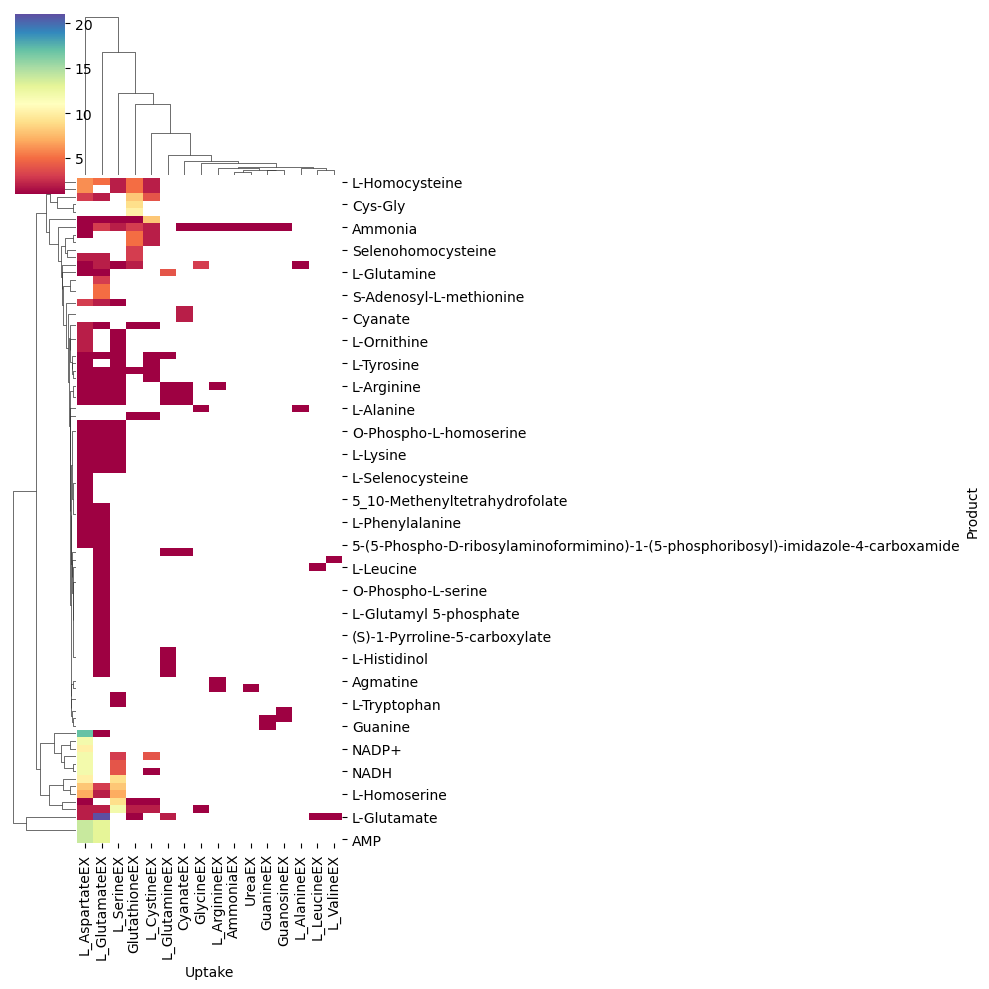

In [47]:
pdf = df_paths.pivot_table(columns='Uptake', index='Product', values='Reaction', aggfunc='count', fill_value=0)

sns.clustermap(pdf, mask=(pdf==0), cmap='Spectral')


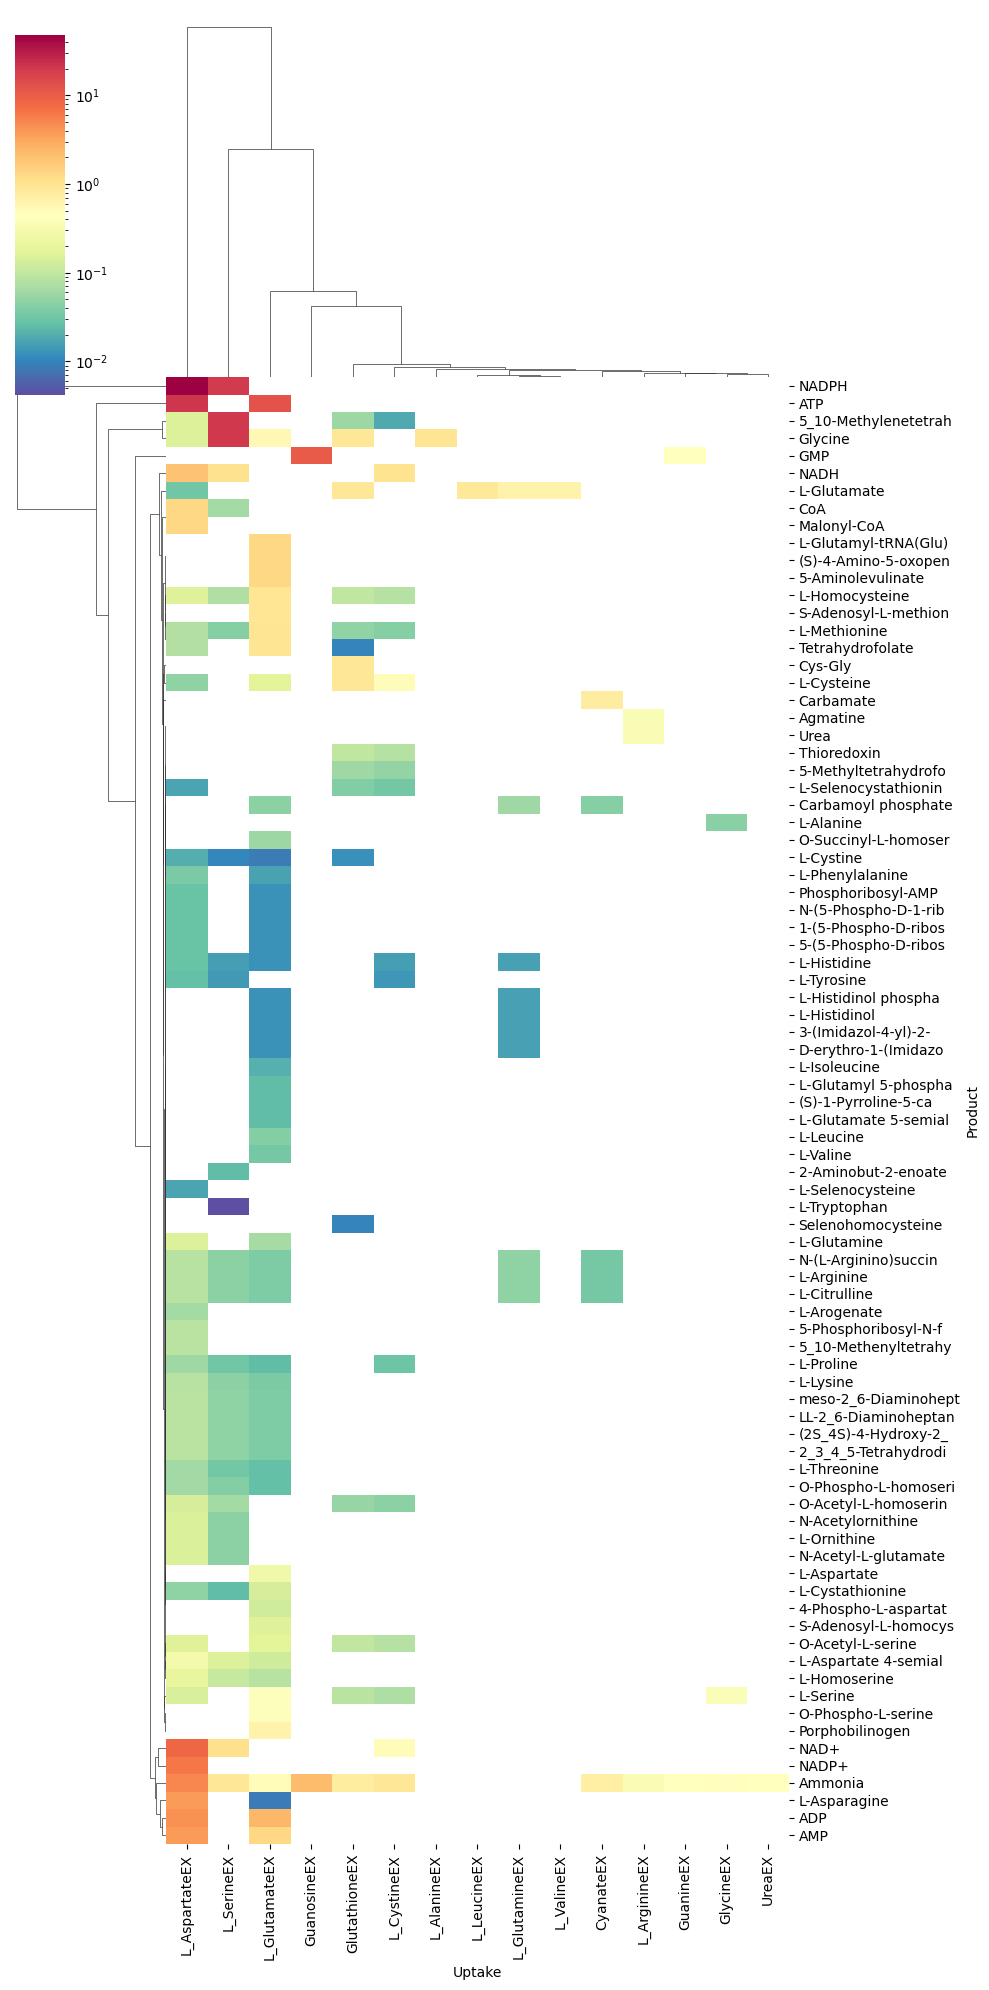

In [48]:

pdf = df_paths.loc[~df_paths.Reaction.str.contains('trans', case=False)].pivot_table(columns='Uptake', index='Product', values='Flux', aggfunc='max', fill_value=0)
sel = (pdf == 0).sum(axis=1) > 2

sns.clustermap(
    pdf.loc[sel], mask=(pdf.loc[sel]==0), cmap='Spectral_r', norm=LogNorm(),
    yticklabels= pdf.loc[sel].index.str.slice(0, 20),
    figsize=(10,20),

              )

In [49]:
pdf

Uptake,CyanateEX,GlutathioneEX,GlycineEX,GuanineEX,GuanosineEX,L_AlanineEX,L_ArginineEX,L_AspartateEX,L_CystineEX,L_GlutamateEX,L_GlutamineEX,L_LeucineEX,L_SerineEX,L_ValineEX,UreaEX
Product,,,,,,,,,,,,,,,
(2S_4S)-4-Hydroxy-2_3_4_5-tetrahydrodipicolinate,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.088287,0.000000,0.038740,0.0,0.0,0.047388,0.0,0.0
(S)-1-Pyrroline-5-carboxylate,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.025861,0.0,0.0,0.000000,0.0,0.0
(S)-4-Amino-5-oxopentanoate,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.288349,0.0,0.0,0.000000,0.0,0.0
1-(5-Phospho-D-ribosyl)-ATP,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.028735,0.000000,0.012609,0.0,0.0,0.000000,0.0,0.0
2-Aminobut-2-enoate,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.025147,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Selenohomocysteine,0.0,0.010375,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
Tetrahydrofolate,0.0,0.010375,0.0,0.0,0.0,0.0,0.000000,0.079546,0.000000,0.982810,0.0,0.0,0.000000,0.0,0.0
Thioredoxin,0.0,0.097777,0.0,0.0,0.0,0.0,0.000000,0.000000,0.082967,0.000000,0.0,0.0,0.000000,0.0,0.0


In [50]:
top_reactions = df_paths.loc[~df_paths.Reaction.str.contains('trans', case=False)].nlargest(n=1000, columns='Flux').Reaction.unique()

In [51]:
top_reactions = df_paths.loc[~df_paths.Reaction.str.contains('trans', case=False)].nlargest(n=300, columns='Flux').Reaction.unique()

In [52]:
(df_paths.loc[~df_paths.Reaction.str.contains('trans', case=False)].groupby('Product').Uptake.nunique() > 1).sum()

54

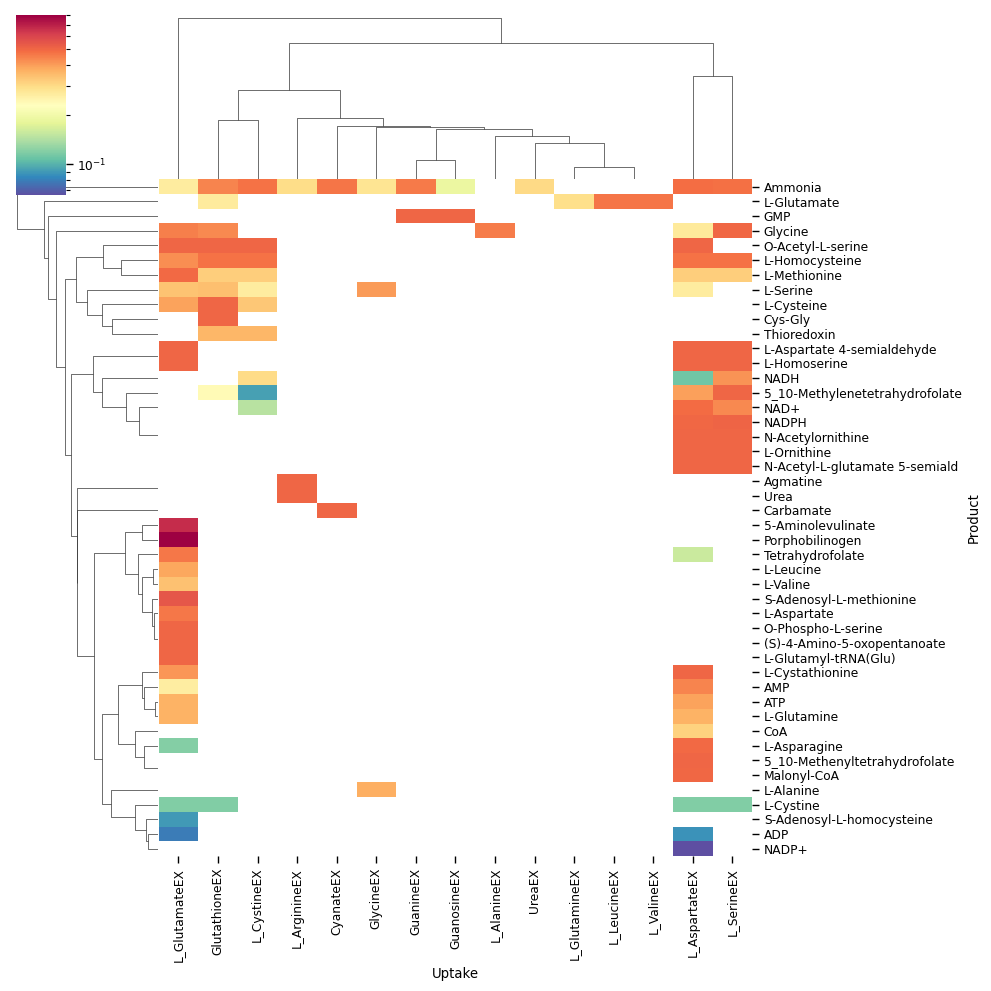

In [53]:
sns.set_context('paper')
pdf = df_paths.loc[df_paths.Reaction.isin(top_reactions)].pivot_table(columns='Uptake', index=['Product',#'Name'
                                                                                              ], values='Percent_Production', aggfunc='max', fill_value=0)
sns.clustermap(
    pdf, mask=(pdf==0), cmap='Spectral_r', norm=LogNorm(),
    figsize=(10,10),
    yticklabels= pdf.index.str.slice(0, 30),

              )

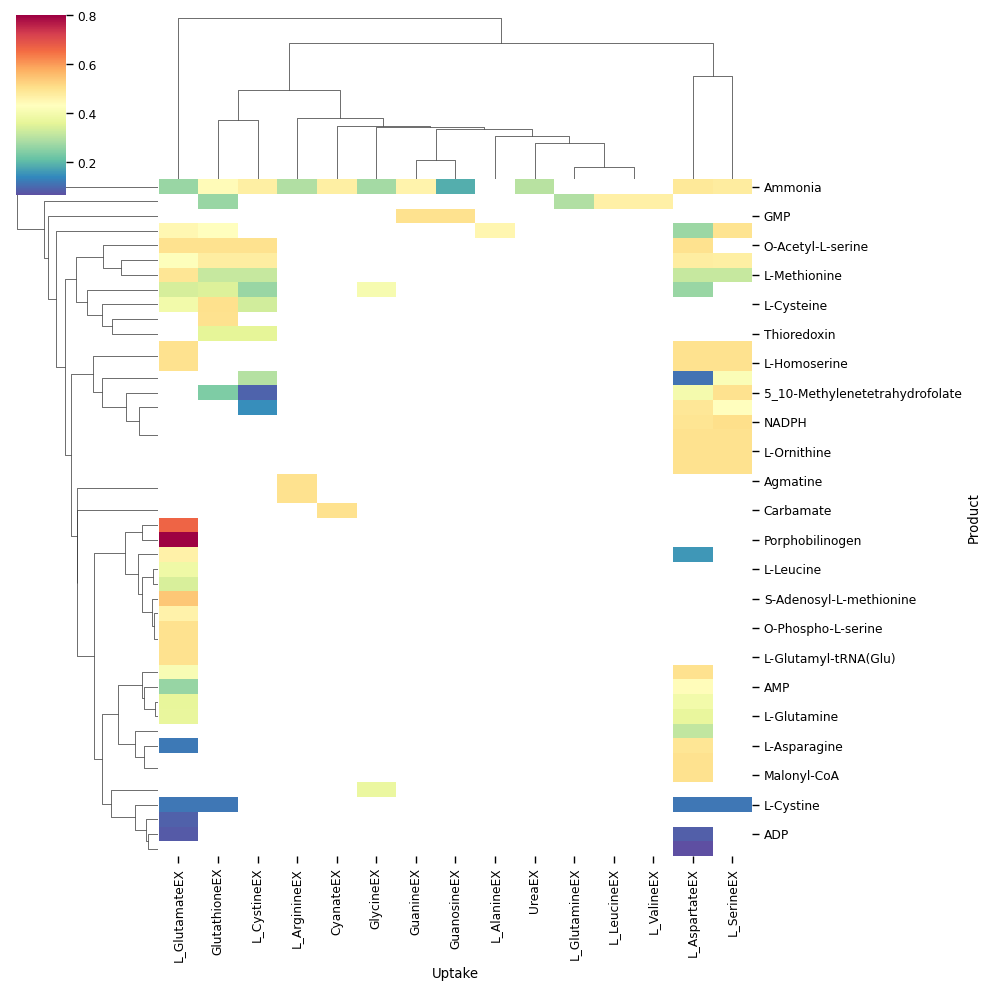

In [54]:
sns.set_context('paper')
pdf = df_paths.loc[df_paths.Reaction.isin(top_reactions)
                  ].pivot_table(columns='Uptake', 
                                index=['Product',#'Name'
                                      ], values='Percent_Production', aggfunc='max', fill_value=0)
sns.clustermap(
    pdf, mask=(pdf==0), cmap='Spectral_r', #norm=LogNorm(),
    figsize=(10,10),
    #yticklabels= pdf.index.str.slice(0, 30),

              )

In [55]:
group_colors

{'Nitrogen metabolism': '#8dd3c7',
 'Arginine and proline metabolism': '#ffffb3',
 'Histidine metabolism': '#bebada',
 'Cysteine and methionine metabolism': '#fb8072',
 'Glycine, serine and threonine metabolism': '#80b1d3',
 'One carbon pool by folate': '#fdb462',
 'Phenylalanine, tyrosine and tryptophan biosynthesis': '#b3de69',
 'Alanine, aspartate and glutamate metabolism': '#fccde5',
 'Purine metabolism': '#d9d9d9',
 'Valine, leucine and isoleucine degradation': '#bc80bd',
 'Other': '#cccccc'}

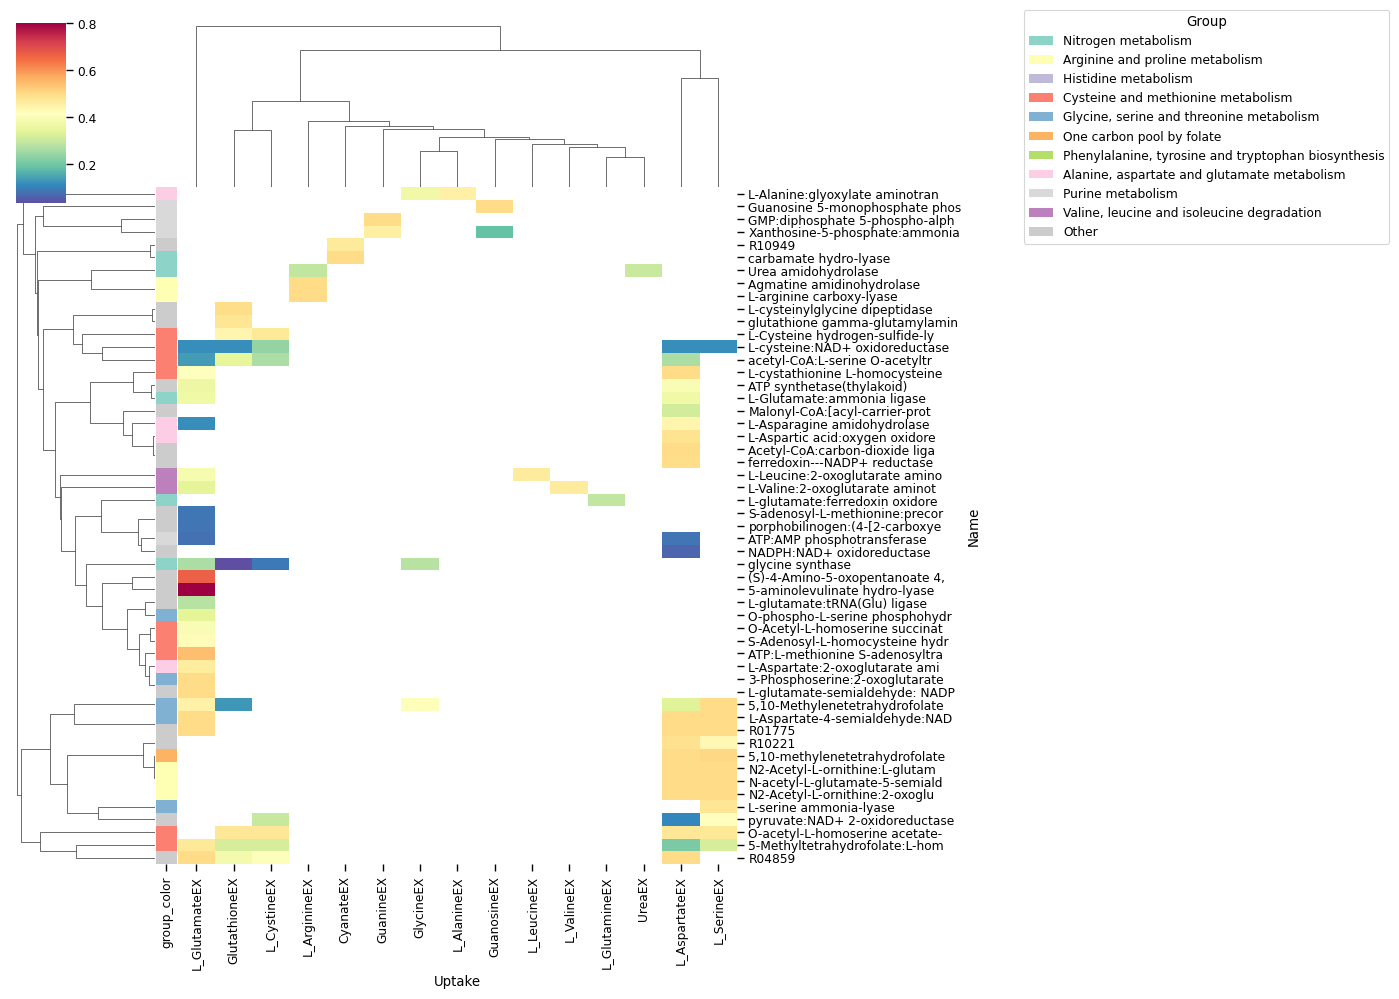

In [56]:
from matplotlib.patches import Patch

pdf = df_paths.loc[df_paths.Reaction.isin(top_reactions)
                  ].pivot_table(columns='Uptake', index=[#'Product',
    'Name'], values='Percent_Production', aggfunc='mean', fill_value=0)
row_colors = df_paths.groupby('Name').group_color.first()

sns.clustermap(
    pdf, mask=(pdf==0), cmap='Spectral_r', #norm=LogNorm(),
    yticklabels= pdf.index.str.slice(0, 30),
    row_colors=row_colors[pdf.index]

              )

handles = [Patch(facecolor=group_colors[name]) for name in group_colors]
plt.legend(handles, group_colors, title='Group',
           bbox_to_anchor=(1.4, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')


In [57]:
pdf

Uptake,CyanateEX,GlutathioneEX,GlycineEX,GuanineEX,GuanosineEX,L_AlanineEX,L_ArginineEX,L_AspartateEX,L_CystineEX,L_GlutamateEX,L_GlutamineEX,L_LeucineEX,L_SerineEX,L_ValineEX,UreaEX
Name,,,,,,,,,,,,,,,
"(S)-4-Amino-5-oxopentanoate 4,5-aminomutase",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000
3-Phosphoserine:2-oxoglutarate aminotransferase,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000
"5,10-Methylenetetrahydrofolate:glycine hydroxymethyltransferase",0.000000,0.132459,0.406530,0.000000,0.000000,0.000000,0.000000,0.334640,0.000000,0.452508,0.000000,0.000000,0.499784,0.000000,0.000000
"5,10-methylenetetrahydrofolate:NADP+ oxidoreductase",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.504829,0.000000,0.000000
5-Methyltetrahydrofolate:L-homocysteine S-methyltransferase,0.000000,0.319858,0.000000,0.000000,0.000000,0.000000,0.000000,0.211503,0.319858,0.472798,0.000000,0.000000,0.319858,0.000000,0.000000
5-aminolevulinate hydro-lyase,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.800000,0.000000,0.000000,0.000000,0.000000,0.000000
ATP synthetase(thylakoid),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.393205,0.000000,0.365292,0.000000,0.000000,0.000000,0.000000,0.000000
ATP:AMP phosphotransferase,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.087592,0.000000,0.079613,0.000000,0.000000,0.000000,0.000000,0.000000
ATP:L-methionine S-adenosyltransferase,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.544116,0.000000,0.000000,0.000000,0.000000,0.000000


In [58]:
#df_paths['weight'] = df_paths['Flux']
df_paths['Line_width'] = (df_paths['Percent_Production'] +0.1) *10

G = nx.from_pandas_edgelist(df_paths, source='Reactant', target='Product', edge_attr=True, 
                            create_using=nx.MultiDiGraph, edge_key='Reaction')

In [59]:
# We could use figure here but don't want all the axes and titles
plot = Plot() # x_range=Range1d(-2, 2), y_range=Range1d(-2, 2))
# Create a Bokeh graph from the NetworkX input using nx.spring_layout
graph = from_networkx(G, nx.nx_agraph.pygraphviz_layout, prog='dot')
plot.renderers.append(graph)

# Set some of the default node glyph (Circle) properties
graph.node_renderer.glyph.update(size=20, fill_color="orange")

# Set some edge properties too
graph.edge_renderer.glyph.update(line_width='Line_width')

graph.node_renderer.data_source.to_df()
#show(plot)

,index
0,Guanosine
1,GMP
2,Ammonia
3,L-Aspartate
4,L-Asparagine
...,...
83,L-Isoleucine
84,Agmatine
85,Cyanate
86,Carbamate


In [60]:
df_paths['Source'] = df_paths['Reactant']
df_paths['Target'] = df_paths['Product']


In [61]:
    met1 = 'CyanateEX'
    df = df_paths.loc[df_paths.Uptake.isin([met1])]
    df.loc[df.Index == 1, 'Source'].unique()


array(['Cyanate'], dtype=object)

In [62]:
df_paths.groupby(['Reaction', 'Group']).size().reset_index().Group.value_counts().head(10)

Transport                                   13
                                            13
Cysteine and methionine metabolism          13
Arginine and proline metabolism             13
Glycine, serine and threonine metabolism    11
Histidine metabolism                         9
Porphyrin and chlorophyll metabolism         6
Lysine biosynthesis                          5
Nitrogen metabolism                          5
Purine metabolism                            5
Name: Group, dtype: int64

In [63]:
top_groups = df_paths.groupby(['Uptake', 'Group']).size().reset_index().Group.value_counts().head(12).index.to_series()
top_groups = top_groups[~top_groups.isin(['', 'Transport'])]
top_groups.shape

(10,)

In [64]:
from bokeh.palettes import all_palettes
gpallete = all_palettes['Set3'][10]
group_colors = dict(zip(top_groups, gpallete)) 
group_colors['Other'] = '#cccccc'
group_colors
df_paths['group_color'] = df_paths.Group.map(group_colors)
df_paths['group_color'] = df_paths['group_color'].fillna(group_colors['Other'])

In [75]:
from bokeh.models.graphs import NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.models import Circle, HoverTool, MultiLine
from bokeh.models import (BoxZoomTool, Circle, HoverTool, WheelZoomTool, PanTool, BoxSelectTool,
                          MultiLine, Plot, Range1d, ResetTool)
from bokeh.layouts import gridplot
#tools='pan,wheel_zoom,box_select'
def _layout_func(x):
    f = nx.nx_agraph.pygraphviz_layout(x)
    return {k: np.asarray(f[k]) for k in f}

    

def _create_plot(df_paths, met1):
    # We could use figure here but don't want all the axes and titles
    df = df_paths.loc[df_paths.Uptake.isin([met1])]
    met_name = df.loc[df.Index == 1, 'Source'].unique()[0]
    
    G = nx.from_pandas_edgelist(df.loc[df.Index != 1], 
                                source='Source', target='Target', edge_attr=True, 
                            create_using=nx.MultiDiGraph, edge_key='Reaction')
    attr_df = pd.DataFrame(G.nodes, columns=['node'])
    attr_df.index = attr_df.node
    attr_df['Type'] = 'Other'
    aa_names = [i.name for i in amino_acid_metabolites]
    attr_df.loc[attr_df.node.isin(aa_names), 'Type'] = 'aa'
    attr_df.loc[attr_df.node.isin(['Ammonia']),'Type'] = 'Ammonia'
    attr_df.loc[attr_df.node.isin([met_name]),'Type'] = 'Uptake'

    attr_df['node_color'] = attr_df['Type'].map(dict(zip(['aa', 'Ammonia', 'Uptake','Other'], (list(all_palettes['Category10'][3]) + [None]))))
    for i in ['node_color', 'Type']:
        nx.set_node_attributes(G, name=i, values=attr_df[i].to_dict())

    plot = Plot(width=200, height=200, #, x_range=Range1d(-2,2), y_range=Range1d(-2,2),
               title=met_name)

    # Create a Bokeh graph from the NetworkX input using nx.spring_layout
    #graph = from_networkx(G, nx.spring_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.spectral_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.multipartite_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.spiral_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.shell_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.planar_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.kamada_kawai_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.bipartite_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.fruchterman_reingold_layout, scale=1.5, center=(0,0))
    graph = from_networkx(G, nx.nx_agraph.pygraphviz_layout, prog='dot')
    # [‘neato’|’dot’|’twopi’|’circo’|’fdp’|’nop’
    #graph = from_networkx(G, nx.nx_agraph.pygraphviz_layout, prog='twopi')
    #graph = from_networkx(G, _layout_func)
    
    plot.renderers.append(graph)

    # Blue circles for nodes, and light grey lines for edges
    graph.node_renderer.glyph = Circle(size=10, fill_color='node_color')
    graph.edge_renderer.glyph = MultiLine(line_color='group_color', line_alpha=0.8, line_width='Line_width')
    #graph.edge_renderer.glyph = MultiLine(line_color="#cccccc", line_alpha=0.8, line_width=4)

    # green hover for both nodes and edges
    graph.node_renderer.hover_glyph = Circle(size=10, fill_color='#abdda4')
    graph.edge_renderer.hover_glyph = MultiLine(line_color='#abdda4', line_width=4)

    # When we hover over nodes, highlight adjecent edges too
    graph.inspection_policy =  NodesAndLinkedEdges()
    graph.selection_policy = EdgesAndLinkedNodes()

    node_hover_tool = HoverTool(tooltips=[("Product", "@index")])
    edge_hover_tool = HoverTool(tooltips=[('Path', '@Reactant --> @Product'),
       ('Reaction', '@Reaction: @Name'),('Definition', '@Definition'), ('Group', '@Group'),
    ])

    plot.add_tools(node_hover_tool, BoxZoomTool(), ResetTool(), WheelZoomTool(), PanTool(), BoxSelectTool() )
    return plot



In [76]:
graph.edge_renderer.data_source.data


{'Reaction': ['Trans_Guanosine',
  'R01227',
  'R01230',
  'AmmoniaTRANS',
  'AspartateTRANS',
  'R00357',
  'R00485',
  'R00485',
  'R01731',
  'R00127',
  'R00086th',
  'R00742',
  'R00253',
  'R01071',
  'R00177',
  'R00480',
  'R01395',
  'R00239',
  'R00485',
  'R01626',
  'R00209',
  'R10221',
  'R01248',
  'R00112',
  'R01158',
  'R00732',
  'R00892',
  'R00209',
  'R01221',
  'FdR',
  'R02291',
  'R03443',
  'R01775',
  'R10147',
  'R01776',
  'R01771',
  'R01776',
  'R01777',
  'R02026',
  'R04945',
  'R00946',
  'R00946',
  'R01286',
  'R01290',
  'R01287',
  'R00945',
  'R00945',
  'R01221',
  'GlycineTRANS',
  'R01221',
  'R00945',
  'R00369',
  'R01220',
  'R01217',
  'R01220',
  'R04326',
  'R04463',
  'GlutamateTRANS',
  'R05578',
  'R05578',
  'R04173',
  'R00355',
  'R00372',
  'R01090',
  'R01214',
  'R02199',
  'R00694',
  'R03260',
  'R03217',
  'R08632',
  'R04859',
  'R00892',
  'R00782',
  'R04859',
  'R00586',
  'R03601',
  'SerineTRANS',
  'R00945',
  'R00945',

In [77]:
from bokeh.plotting import figure
from bokeh import events
from bokeh.models import CustomJS, Div, Button
from bokeh.layouts import column, row

m = 'GlycineEX'
p = _create_plot(df_paths, m) 

# item_list = 
# legend = Legend(items=[
#     LegendItem(label="orange", renderers=[r], index=0),
#     LegendItem(label="red", renderers=[r], index=1),
# ])
# p.add_layout(legend)
# div = Div(width=400)
# layout = column(p, div)

# p.js_on_event(events.SelectionGeometry, CustomJS(args=dict(div=div), code="""
# div.text = "Selection! <p> <p>" + JSON.stringify(cb_obj.geometry, undefined, 2);
# """))

# show(layout)
show(p)

In [78]:
from bokeh.io import output_file, show
output_file("aa_production.html")
plots = [_create_plot(df_paths, m) for m in df_paths.Uptake.unique()]
# put all the plots in a gridplot
p = gridplot(plots, ncols=4)


#plot.add_tools(HoverTool(tooltips=None))

show(p)

ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : key "line_color" value "group_color", key "line_width" value "Line_width" [renderer: GlyphRenderer(id='10604', ...)]
ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : key "fill_color" value "node_color" [renderer: GlyphRenderer(id='10600', ...)]


ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : key "line_color" value "group_color", key "line_width" value "Line_width" [renderer: GlyphRenderer(id='10604', ...)]
ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : key "fill_color" value "node_color" [renderer: GlyphRenderer(id='10600', ...)]


In [ ]:
df_paths.to_excel('MED4_paths_to_ammonia.xlsx')

In [ ]:
model.groups[3].members, model.groups[3].name, model.groups[3].annotation

In [ ]:
[g for g in model.groups if r in g.members][0].name

In [ ]:

# -*- coding: utf-8 -*-

import networkx as nx

from bokeh.plotting import figure, from_networkx, curdoc
from bokeh.models import Rect, HoverTool,  TextInput
from bokeh.layouts import column

global graph
G = nx.Graph()

field = TextInput(value="first", title="Graph to select: ")

def graphe(base, H):
    for i in range(0,10):
        H.add_node(base+str(i), {'name':base+str(i),
                            'version': str(i),
                            'width': .2,
                            'offset':- 25,
                             'color': ' red'})
        H.add_edge(base +str(0), base+str(i))

def update(attr, old, new):
    newG = nx.Graph()
    graphe(new, newG)
    newplot = figure(title="RPM network", width= 1500, height= 800, x_range=(-2.1, 2.1), y_range=(-2.1, 2.1),
              tools="", toolbar_location=None)
    newgraph = from_networkx(newG, nx.spring_layout, scale=4, center=(0,0))
    newgraph.node_renderer.glyph = Rect(height=0.1, width="width", fill_color="color")
    newplot.add_tools(hover)
    newplot.renderers.append(newgraph)
    layout.children[1] = newplot

graphe("first", G)
plot = figure(title="RPM network", width= 1500, height= 800, x_range=(-2.1, 2.1), y_range=(-2.1, 2.1),
              tools="", toolbar_location=None)

hover = HoverTool()
hover.tooltips = """
<div style=padding=5px>@name</div>
<div style=padding=5px>@version</div>
"""
plot.add_tools(hover)
graph = from_networkx(G, nx.spring_layout, scale=4, center=(0,0))
graph.node_renderer.glyph = Rect(height=0.1, width="width", fill_color="color")
plot.renderers.append(graph)
field.on_change('value', update)

layout = column(field, plot)
curdoc().add_root(layout)



In [126]:
#reaction_names = [r.name for r in model.reactions]
group_df = pd.DataFrame.from_records([{'Group' : g.name, 'Reaction Name': r.name, 'Reaction': r.id, 'Gene' : ge.id} 
                                      for g in model.groups for 
                                      r in g.members 
                                      for ge in r.genes ])


In [128]:
RNA_dpath =os.path.join('data', 'RNASEQ') 
pmm_df = pd.read_csv(os.path.join(RNA_dpath, 'MED4_PMM2locus.csv'), names=['gene_id', 'pmm'])
deseq_df = pd.read_csv(os.path.join(RNA_dpath, 'MED4_DE_genes_DESEQ_wKEGG.csv'))

group_df = pd.merge(group_df, pmm_df, left_on='Gene', right_on='pmm', how='left')
cols = ['gene_id', 'gene', 'product', 'status', 'sub', 'path', 'ecpath',
       'baseMean', 'log2FoldChange',  'padj',
       ]
group_df = pd.merge(group_df, deseq_df[cols], on='gene_id', 
         how='left', suffixes=['', '_de'])
group_df

,Group,Reaction Name,Reaction,Gene,gene_id,pmm,gene,product,status,sub,path,ecpath,baseMean,log2FoldChange,padj
0,"Alanine, aspartate and glutamate metabolism",aspartoacylase,R00546,PMM0222,TX50_RS01145,PMM0222,TX50_RS01145,aspartoacylase,no_significant,09105 Amino acid metabolism,"00250 Alanine, aspartate and glutamate metabolism [PATH:ko00250] // 00340 Histidine metabolism [PATH:ko00340]","K01437 ASPA, aspA; aspartoacylase [EC:3.5.1.15]",130.131548,-0.398118,0.143522
1,"Alanine, aspartate and glutamate metabolism",L-Aspartate:2-oxoglutarate aminotransferase,R00355,PMM0674,TX50_RS03585,PMM0674,TX50_RS03585,pyridoxal phosphate-dependent aminotransferase,down,09105 Amino acid metabolism // 09110 Biosynthesis of other secondary metabolites // 09181 Protein families: metabolism,"00250 Alanine, aspartate and glutamate metabolism [PATH:ko00250] // 00270 Cysteine and methionine metabolism [PATH:ko00270] // 00220 Arginine biosynthesis [PATH:ko00220] // 00330 Arginine and proline metabolism [PATH:ko00330] // 00350 Tyrosine metabolism [PATH:ko00350] // 00360 Phenylalanine metabolism [PATH:ko00360] // 00400 Phenylalanine, tyrosine and tryptophan biosynthesis [PATH:ko00400] // 00950 Isoquinoline alkaloid biosynthesis [PATH:ko00950] // 00960 Tropane, piperidine and pyridine alkaloid biosynthesis [PATH:ko00960] // 00401 Novobiocin biosynthesis [PATH:ko00401] // 01007 Amino acid related enzymes [BR:ko01007]",K00812 aspB; aspartate aminotransferase [EC:2.6.1.1],360.325837,-0.778083,0.000351
2,"Alanine, aspartate and glutamate metabolism",L-Aspartic acid:oxygen oxidoreductase,R00357,PMM0100,TX50_RS00530,PMM0100,nadB,L-aspartate oxidase,up,09105 Amino acid metabolism // 09108 Metabolism of cofactors and vitamins,"00250 Alanine, aspartate and glutamate metabolism [PATH:ko00250] // 00760 Nicotinate and nicotinamide metabolism [PATH:ko00760]",K00278 nadB; L-aspartate oxidase [EC:1.4.3.16],398.171564,0.558454,0.002005
3,"Alanine, aspartate and glutamate metabolism",L-Alanine:glyoxylate aminotransferase,R00369,PMM0919,TX50_RS04905,PMM0919,TX50_RS04905,alanine--glyoxylate aminotransferase family protein,down,09101 Carbohydrate metabolism // 09102 Energy metabolism // 09105 Amino acid metabolism // 09141 Transport and catabolism // 09181 Protein families: metabolism,"00630 Glyoxylate and dicarboxylate metabolism [PATH:ko00630] // 00680 Methane metabolism [PATH:ko00680] // 00250 Alanine, aspartate and glutamate metabolism [PATH:ko00250] // 00260 Glycine, serine and threonine metabolism [PATH:ko00260] // 04146 Peroxisome [PATH:ko04146] // 01007 Amino acid related enzymes [BR:ko01007]",K00830 AGXT; alanine-glyoxylate transaminase / serine-glyoxylate transaminase / serine-pyruvate transaminase [EC:2.6.1.44 2.6.1.45 2.6.1.51],968.783304,-0.536196,0.000856
4,"Alanine, aspartate and glutamate metabolism",L-Asparagine amidohydrolase,R00485,PMM0821,TX50_RS04400,PMM0821,TX50_RS04400,asparaginase,no_significant,09105 Amino acid metabolism // 09106 Metabolism of other amino acids,"00250 Alanine, aspartate and glutamate metabolism [PATH:ko00250] // 00460 Cyanoamino acid metabolism [PATH:ko00460]","K01424 E3.5.1.1, ansA, ansB; L-asparaginase [EC:3.5.1.1]",218.466852,0.195417,0.448622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964,tRNA Formation,tRNA Formation,tRNAFormation,PMM1535,TX50_RS08230,PMM1535,TX50_RS08230,DNA-directed RNA polymerase subunit alpha,down,09121 Transcription // 09182 Protein families: genetic information processing,03020 RNA polymerase [PATH:ko03020] // 03021 Transcription machinery [BR:ko03021] // 03400 DNA repair and recombination proteins [BR:ko03400],K03040 rpoA; DNA-directed RNA polymerase subunit alpha [EC:2.7.7.6],5063.700039,-0.565906,0.005708
965,tRNA Formation,tRNA Formation,tRNAFormation,PMM1431,TX50_RS07710,PMM1431,TX50_RS07710,DNA-directed RNA polymerase subunit omega,no_significant,NaN,NaN,NaN,456.483578,0.023011,0.943278
966,tRNA Formation,tRNA Formation,tRNAFormation,PMM1483,TX50_RS07965,PMM1483,TX50_RS079

In [120]:
group_df.loc[group_df['product'].isna()]

,Group,Reaction,Gene,gene_id,pmm,gene,product,status,sub,path,ecpath,baseMean,log2FoldChange,padj


In [121]:
group_df.shape

(969, 14)

In [125]:
len(model.genes)

595

In [129]:
deseq_df

,gene_id,gene,product,status,main,sub,path,ecpath,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,contrast,Length,organism,protein_id
0,TX50_RS00020,dnaN,DNA polymerase III subunit beta,no_significant,09120 Genetic Information Processing // 09180 Brite Hierarchies,09124 Replication and repair // 09182 Protein families: genetic information processing,03030 DNA replication [PATH:ko03030] // 03430 Mismatch repair [PATH:ko03430] // 03440 Homologous recombination [PATH:ko03440] // 03032 DNA replication proteins [BR:ko03032] // 03400 DNA repair and recombination proteins [BR:ko03400],K02338 dnaN; DNA polymerase III subunit beta [EC:2.7.7.7],1548.906501,0.228545,0.240451,0.950483,0.341867,0.461968,treatment_long.term_vs_ref,1155,MED4,WP_011131639.1
1,TX50_RS00025,TX50_RS00025,hypothetical protein,down,NaN,NaN,NaN,NaN,119.583771,-0.780791,0.232356,-3.360329,0.000778,0.003090,treatment_long.term_vs_ref,705,MED4,WP_011131640.1
2,TX50_RS00030,purL,phosphoribosylformylglycinamidine synthase subunit PurL,up,09100 Metabolism,09104 Nucleotide metabolism,00230 Purine metabolism [PATH:ko00230],K23269 purL; phosphoribosylformylglycinamidine synthase subunit PurL [EC:6.3.5.3],739.556937,0.776969,0.230531,3.370346,0.000751,0.003003,treatment_long.term_vs_ref,2337,MED4,WP_011131641.1
3,TX50_RS00035,purF,amidophosphoribosyltransferase,no_significant,09100 Metabolism // 09180 Brite Hierarchies,09104 Nucleotide metabolism // 09105 Amino acid metabolism // 09181 Protein families: metabolism,"00230 Purine metabolism [PATH:ko00230] // 00250 Alanine, aspartate and glutamate metabolism [PATH:ko00250] // 01002 Peptidases and inhibitors [BR:ko01002]","K00764 purF, PPAT; amidophosphoribosyltransferase [EC:2.4.2.14]",362.706295,0.112800,0.131087,0.860498,0.389514,0.508454,treatment_long.term_vs_ref,1458,MED4,WP_011131642.1
4,TX50_RS00040,TX50_RS00040,DNA topoisomerase 4 subunit A,no_significant,09180 Brite Hierarchies,09182 Protein families: genetic information processing,03032 DNA replication proteins [BR:ko03032] // 03400 DNA repair and recombination proteins [BR:ko03400],K02469 gyrA; DNA gyrase subunit A [EC:5.6.2.2],725.124805,-0.254635,0.214104,-1.189304,0.234320,0.342085,treatment_long.term_vs_ref,2439,MED4,WP_011131643.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1850,TX50_RS09870,TX50_RS09870,hypothetical protein,no_significant,NaN,NaN,NaN,NaN,31.874926,0.008389,0.313691,0.026743,0.978665,0.985687,treatment_long.term_vs_ref,168,MED4,WP_225866747.1
1851,TX50_RS09875,TX50_RS09875,hypothetical protein,down,NaN,NaN,NaN,NaN,64.121267,-0.612455,0.307097,-1.994336,0.046115,0.095186,treatment_long.term_vs_ref,165,MED4,WP_225866749.1
1852,TX50_RS09880,TX50_RS09880,SxtJ family membrane protein,no_significant,NaN,NaN,NaN,NaN,101.505886,-0.340990,0.283397,-1.203224,0.228890,0.337350,treatment_long.term_vs_ref,378,MED4,WP_011132879.1
1853,TX50_RS09885,TX50_RS09885,DUF5989 family protein,down,NaN,NaN,NaN,NaN,117.995639,-0.311205,0.141979,-2.191909,0.028386,0.064985,treatment_long.term_vs_ref,159,MED4,WP_225866752.1


In [132]:
group_df['ko'] = group_df.ecpath.str.partition(' ', )[0]

In [157]:
df_paths_with_ko = pd.merge(df_paths, group_df, on='Reaction', how='outer')

In [158]:
pallete = all_palettes['Category20'][16]
df_paths_with_ko['color'] = df_paths_with_ko.Uptake.map(dict(zip(df_paths_with_ko.Uptake.unique(), pallete)))

In [159]:
df_paths_with_ko.shape, df_paths.shape

((1915, 32), (575, 16))

In [160]:
cols = ['Uptake', 'ko', 'color', 'Reaction', 'Name', 'Flux',
       'Definition', 'Percent_Production', 'Group_x', 'Group_Annotation',
       'Reactant', 
         'gene_id',  'product', 'status', 'path', 'ecpath', 'baseMean', 'log2FoldChange', 'padj']
df_paths_with_ko = df_paths_with_ko[cols].dropna(subset=['Uptake', 'ko']).drop_duplicates(subset=['Uptake', 'ko'])

In [161]:
df_paths_with_ko.columns

Index(['Uptake', 'ko', 'color', 'Reaction', 'Name', 'Flux', 'Definition',
       'Percent_Production', 'Group_x', 'Group_Annotation', 'Reactant',
       'gene_id', 'product', 'status', 'path', 'ecpath', 'baseMean',
       'log2FoldChange', 'padj'],
      dtype='object')

In [162]:
df_paths_with_ko.to_excel('MED4_paths_to_aa_kegg.xlsx')

In [164]:
df_paths

,path_id,Index,Uptake,Product,Reaction,Name,Flux,Definition,Percent_Production,Group,Group_Annotation,Reactant,group_color,Line_width,Source,Target
0,1,1,GuanosineEX,Guanosine,Trans_Guanosine,Trans_Guanosine,10.557712,Guanosine[e] <=> Guanosine[c],0.499994,,,Guanosine,#cccccc,5.999943,Guanosine,Guanosine
1,1,2,GuanosineEX,GMP,R01227,Guanosine 5-monophosphate phosphohydrolase,10.557644,GMP[c] + H2O[c] <=> Guanosine[c] + Orthophosphate[c],0.499943,Purine metabolism,SBO:0000633,Guanosine,#d9d9d9,5.999427,Guanosine,GMP
2,1,3,GuanosineEX,Ammonia,R01230,Xanthosine-5-phosphate:ammonia ligase,2.303622,ATP[c] + Ammonia[c] + Xanthosine_5_phosphate[c] <=> AMP[c] + Diphosphate[c] + GMP[c],0.187664,Purine metabolism,SBO:0000633,GMP,#d9d9d9,2.876642,GMP,Ammonia
0,1,1,L_AspartateEX,L-Aspartate,AspartateTRANS,L_Aspartate Transport,9.509822,L_Aspartate[c] <=> L_Aspartate[e],0.497644,Transport,SBO:0000633,L-Aspartate,#cccccc,5.976440,L-Aspartate,L-Aspartate
1,1,2,L_AspartateEX,Ammonia,R00357,L-Aspartic acid:oxygen oxidoreductase,5.112795,H2O[c] + L_Aspartate[c] + Oxygen[c] --> Ammonia[c] + Hydrogen_peroxide[c] + Oxaloacetate[c],0.484834,"Alanine, aspartate and glutamate metabolism",SBO:0000633,L-Aspartate,#fccde5,5.848339,L-Aspartate,Ammonia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1,1,L_ValineEX,L-Valine,ValineTRANS,L_Valine Transport,0.650805,L_Valine[c] <=> L_Valine[e],0.490913,Transport,SBO:0000633,L-Valine,#cccccc,5.909130,L-Valine,L-Valine
1,1,2,L_ValineEX,L-Glutamate,R01214,L-Valine:2-oxoglutarate aminotransferase,0.624487,2_Oxoglutarate[c] + L_Valine[c] <=> 3_Methyl_2_oxobutanoic_acid[c] + L_Glutamate[c],0.466974,"Valine, leucine and isoleucine degradation",SBO:0000633,L-Valine,#bc80bd,5.669744,L-Valine,L-Glutamate
0,1,1,GuanineEX,Guanine,Trans_Guanine,Trans_Guanine,0.443825,Guanine[e] <=> Guanine[c],0.499981,,,Guanine,#cccccc,5.999805,Guanine,Guanine
1,1,2,GuanineEX,GMP,R01229,GMP:diphosphate 5-phospho-alpha-D-ribosyltransferase,0.443801,Diphosphate[c] + GMP[c] <=> 5_Phospho_alpha_D_ribose_1_diphosphate[c] + Guanine[c],0.499739,Purine metabolism,SBO:0000633,Guanine,#d9d9d9,5.997395,Guanine,GMP


In [174]:
rid = 'R01229'
df_paths['genes'] = df_paths.Reaction.map( lambda x: [g.id for g in model.reactions.get_by_id(x).genes])

In [176]:
df_paths_genes = df_paths.explode(column='genes', ignore_index=True, )

In [190]:
pallete = all_palettes['Category20'][16]
df_paths_genes['color'] = df_paths_genes.Uptake.map(dict(zip(sorted(df_paths_genes.Uptake.unique()), pallete)))

In [191]:
df_paths_genes[['Uptake', 'genes', 'color']].dropna(subset='genes').drop_duplicates().to_excel('aa_uptake_kegg.xlsx')

In [192]:
print('\n'.join(sorted(df_paths_genes.Uptake.unique())))

AmmoniaEX
CyanateEX
GlutathioneEX
GlycineEX
GuanineEX
GuanosineEX
L_AlanineEX
L_ArginineEX
L_AspartateEX
L_CystineEX
L_GlutamateEX
L_GlutamineEX
L_LeucineEX
L_SerineEX
L_ValineEX
UreaEX


In [193]:
sns.color_palette(all_palettes['Category20'][16])

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451)]